# Simple Cell Segmentation with a Single-layer Perceptron
Nanyan "Rosalie" Zhu and Chen "Raphael" Liu.

#### Import the necessary packages.

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt
from helper import rescaling

#### Load a sample microscopy cell image.

In [2]:
cell_image_path = './data/sample_cell_img.tif'
cell_image = plt.imread(cell_image_path)

Max intensity: 4095 
Mean intensity: 248.141166556145 
Min intensity: 120


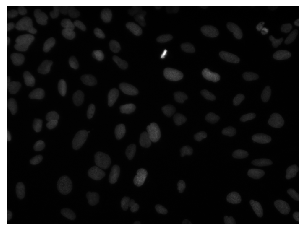

In [3]:
plt.imshow(cell_image, cmap = 'gray')
plt.axis('off');
print('Max intensity: %s \nMean intensity: %s \nMin intensity: %s' % (cell_image.max(), cell_image.mean(), cell_image.min()))

#### Adjust the image to satisfy our human eyes.
Also it is generally a good practise to rescale the image intensity to between 0 and 1 if these pixel values are going to be fed as inputs to a neural network.

Max intensity: 1.0 
Mean intensity: 0.09958455 
Min intensity: 0.0


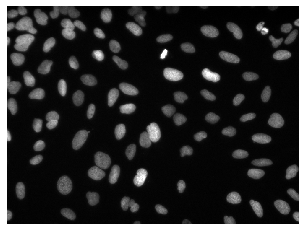

In [4]:
adjusted_cell_image = rescaling(np.float32(cell_image), lower_fraction = 0.001, upper_fraction = 0.999, out_range = (0, 1))
plt.imshow(adjusted_cell_image, cmap = 'gray')
plt.axis('off');
print('Max intensity: %s \nMean intensity: %s \nMin intensity: %s' % (adjusted_cell_image.max(), adjusted_cell_image.mean(), adjusted_cell_image.min()))

#### Note that this image is fairly easy to segment semantically. A simple thresholding will do the job.

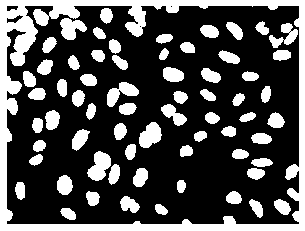

In [5]:
segmented_cell_image = np.int16(adjusted_cell_image > adjusted_cell_image.mean())
plt.imshow(segmented_cell_image, cmap = 'gray')
plt.axis('off');

#### Crop out a small patch with one single cell.

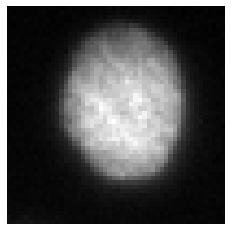

In [6]:
single_cell_image = adjusted_cell_image[0:50, 210:260]
segmented_single_cell_image = segmented_cell_image[0:50, 210:260]
plt.imshow(single_cell_image, cmap = 'gray')
plt.axis('off');

### Now we are going to use a single-layered perceptron to perform a semantic segmentation task.
Credit to [this Medium Post](https://medium.com/@tomgrek/building-your-first-neural-net-from-scratch-with-pytorch-56b0e9c84d54).


This is probably the easiest neural network that you will ever see. It has the simplest structure and does the simplest function. It consists of 1 single layer, 1 single neuron/node, and the input/output pair each consists of 1 tensor of size 1 (aka, a scalar). It is supposed to map the pixel intensity in the cell image to the segmentation result for that pixel (whether or not the pixel belongs to a cell). It only uses the information on each specific pixel itself without looking at any of the surroundings or the global picture.

We used a sigmoid activation function because the task is a binary classification task.

- Input: a scalar representing the pixel intensity.
- Output: a scalar representing the likelihood for the corresponding input scalar to belong to a cell.

#### Build a single-layered perceptron.

In [7]:
class single_layer_perceptron(nn.Module):
    def __init__(self):
        super(single_layer_perceptron, self).__init__()
        self.fc1 = nn.Linear(1,1)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

In [8]:
our_single_layer_perceptron = single_layer_perceptron()
print(our_single_layer_perceptron)

single_layer_perceptron(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)


#### Define our loss function and optimizer

In [9]:
def criterion(out, label):
    return (label - out)**2
optimizer = optim.SGD(our_single_layer_perceptron.parameters(), lr=0.01, momentum=0.5)

#### How do we train our percepron?

We can select the pixels from the cell image as the input, and the corresponding pixels in the segmented (by simple thresholding) as the ground truth to guide the training. We are going to use the pixels in the single-cell image that we just cropped out recently as our test set. **We need to make sure not to use the data in the test set to train our perceptron.**

In [10]:
training_input = adjusted_cell_image[100:200, 0:100].flatten()
ground_truth = segmented_cell_image[100:200, 0:100].flatten()

# Reshape the horizonal arrays to vertical arrays.
training_input = np.reshape(training_input, (len(training_input), 1))
ground_truth = np.reshape(ground_truth, (len(ground_truth), 1))

# Stack them together
training_data = np.hstack((training_input, ground_truth))

In [11]:
# training_data consists of 2 columns: pixel value and segmentation ground truth (0 or 1).
training_data

array([[0.06533262, 0.        ],
       [0.05624202, 0.        ],
       [0.0595477 , 0.        ],
       ...,
       [0.02731738, 0.        ],
       [0.02401171, 0.        ],
       [0.02483813, 0.        ]], dtype=float32)

In [12]:
for epoch in range(10):
    for iteration, training_input_GT_pair in enumerate(training_data):
        training_input, GT = iter(training_input_GT_pair)
        training_input, GT = Variable(torch.FloatTensor([training_input]), requires_grad = True), \
                             Variable(torch.FloatTensor([GT]), requires_grad = False)
        optimizer.zero_grad()
        outputs = our_single_layer_perceptron(training_input)
        loss = criterion(outputs, GT)
        loss.backward()
        optimizer.step()
        if (iteration % 1e4 == 0):
            print("Epoch {} - loss: {}".format(epoch, loss.data[0]))

Epoch 0 - loss: 0.1753772348165512
Epoch 1 - loss: 0.13715100288391113
Epoch 2 - loss: 0.09776442497968674
Epoch 3 - loss: 0.07943215221166611
Epoch 4 - loss: 0.06893766671419144
Epoch 5 - loss: 0.06216994300484657
Epoch 6 - loss: 0.0574478916823864
Epoch 7 - loss: 0.05395994707942009
Epoch 8 - loss: 0.05126890540122986
Epoch 9 - loss: 0.04912013188004494


In [13]:
print('What''s the probability for a cell image pixel with value 0.1 to belong to a cell? ', \
      our_single_layer_perceptron(Variable(torch.Tensor([[[0.1]]]))).cpu().detach().numpy()[0][0][0])

print('What''s the probability for a cell image pixel with value 0.2 to belong to a cell? ', \
      our_single_layer_perceptron(Variable(torch.Tensor([[[0.2]]]))).cpu().detach().numpy()[0][0][0])

print('What''s the probability for a cell image pixel with value 0.5 to belong to a cell? ', \
      our_single_layer_perceptron(Variable(torch.Tensor([[[0.5]]]))).cpu().detach().numpy()[0][0][0])

Whats the probability for a cell image pixel with value 0.1 to belong to a cell?  0.3170357
Whats the probability for a cell image pixel with value 0.2 to belong to a cell?  0.6703968
Whats the probability for a cell image pixel with value 0.5 to belong to a cell?  0.99418914


#### Let's try it out on our test image (the single-cell cropped-out image).

In [14]:
predicted_segmentation = np.zeros(single_cell_image.shape)

for current_row in range(predicted_segmentation.shape[0]):
    for current_column in range(predicted_segmentation.shape[1]):
        current_pixel_value = single_cell_image[current_row, current_column]
        predicted_segmentation[current_row, current_column] = our_single_layer_perceptron(Variable(torch.Tensor([[[current_pixel_value]]]))).cpu().detach().numpy()[0][0][0]
        
# Although we used a sigmoid activation function, the output is still not going to be exactly 0 or 1. We need to binarize the output anyway.
predicted_segmentation = np.int16(predicted_segmentation > 0.5)

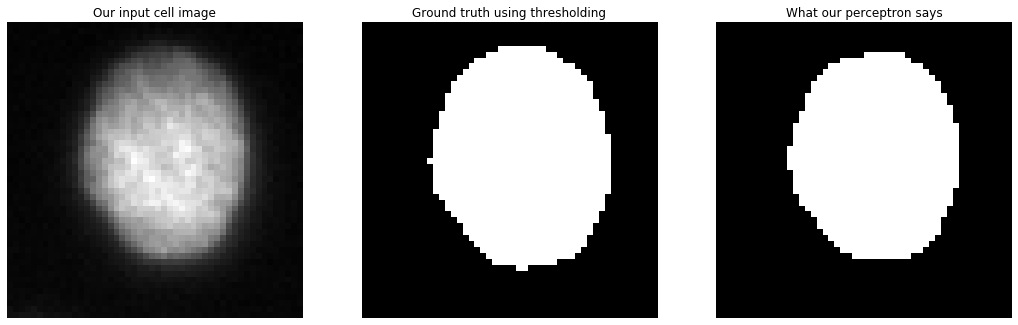

In [15]:
plt.rcParams['figure.figsize'] = [18, 10]

plt.subplot(1, 3, 1)
plt.imshow(single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Our input cell image');
plt.subplot(1, 3, 2)
plt.imshow(segmented_single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Ground truth using thresholding');
plt.subplot(1, 3, 3)
plt.imshow(predicted_segmentation, cmap = 'gray'); plt.axis('off'); plt.title('What our perceptron says');